In [1]:
#Initial implementation from Kaggle: https://www.kaggle.com/rvislaywade/visualizing-mnist-using-a-variational-autoencoder

## General Imports ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Autoencoder ###
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras import backend as K 

from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Input

from tensorflow.keras.datasets import mnist

K.clear_session()

np.random.seed(237)


  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# filter 0, 1, 2
#train_filter = np.where((y_train == 0 ) | (y_train == 1) | (y_train == 2))
#test_filter = np.where((y_test == 0) | (y_test == 1) | (y_test == 2))

# filter 0, 1, 2, 3, 4
train_filter = np.where((y_train == 0 ) | (y_train == 1) | (y_train == 2) | (y_train == 3) | (y_train == 4))
test_filter = np.where((y_test == 0) | (y_test == 1) | (y_test == 2) | (y_test == 3) | (y_test == 4))


X_train, y_train = X_train[train_filter], y_train[train_filter]
X_test, y_test = X_test[test_filter], y_test[test_filter]


In [5]:
# normalization and reshape
shape_x = 28
shape_y = 28

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = X_train.reshape(-1,shape_x,shape_y,1)
X_test = X_test.reshape(-1,shape_x,shape_y,1)

In [6]:
img_shape = (28, 28, 1)    # for MNIST
batch_size = 16 # batch size 
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

In [8]:
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [9]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [10]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [11]:
vae.fit(x=X_train, y=None,
        shuffle=True,
        epochs=7,
        batch_size=batch_size,
        validation_data=(X_test, None))

Train on 30596 samples, validate on 5139 samples
Epoch 1/7
30596/30596 [==============================] - 184s 6ms/sample - loss: 0.5170 - val_loss: 0.1869
Epoch 2/7
30596/30596 [==============================] - 184s 6ms/sample - loss: 0.1818 - val_loss: 0.1768
Epoch 3/7
30596/30596 [==============================] - 190s 6ms/sample - loss: 0.1763 - val_loss: 0.1725
Epoch 4/7
30596/30596 [==============================] - 186s 6ms/sample - loss: 0.1736 - val_loss: 0.1716
Epoch 5/7
30596/30596 [==============================] - 183s 6ms/sample - loss: 0.1717 - val_loss: 0.1706
Epoch 6/7
30596/30596 [==============================] - 184s 6ms/sample - loss: 0.1703 - val_loss: 0.1737
Epoch 7/7
30596/30596 [==============================] - 191s 6ms/sample - loss: 0.1693 - val_loss: 0.1733


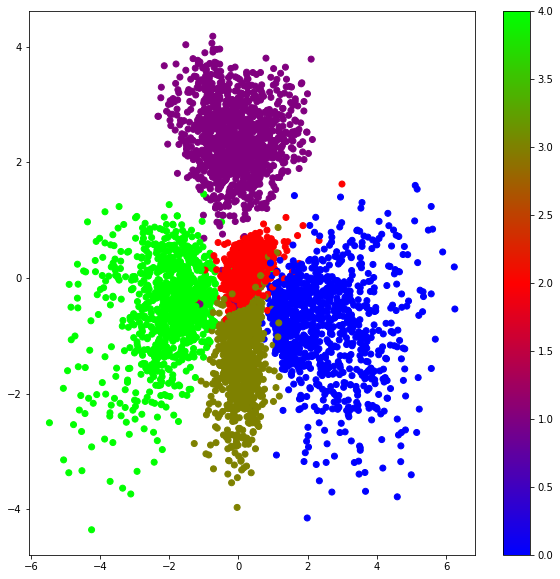

In [12]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_test, cmap='brg')
plt.colorbar()
plt.show()

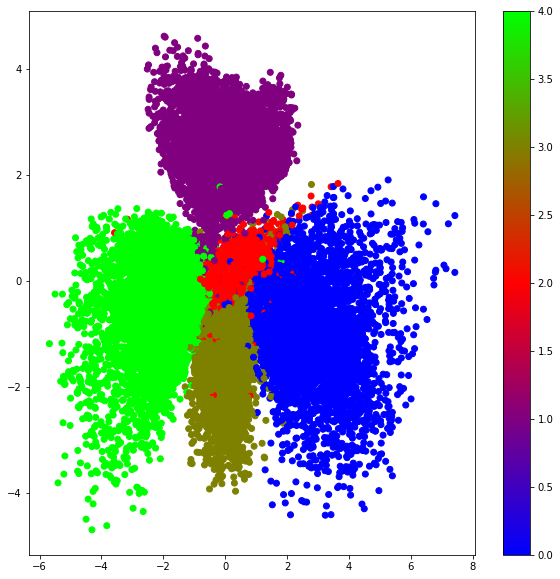

In [13]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
data = encoder.predict(X_train, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(data[:, 0], data[:, 1], c=y_train, cmap='brg')
plt.colorbar()
plt.show()

In [13]:
df = pd.DataFrame(data=data)
df.columns=['x0','x1']
df['label'] = y_train

In [15]:
df.shape

(18623, 3)

In [16]:
df.to_csv("mnist5_train.csv")

In [17]:
df = pd.DataFrame(data=x_valid_noTest_encoded)
df.columns=['x0','x1']
df['label'] = y_test
df.shape

(3147, 3)

In [18]:
df.to_csv("mnist5_test.csv")

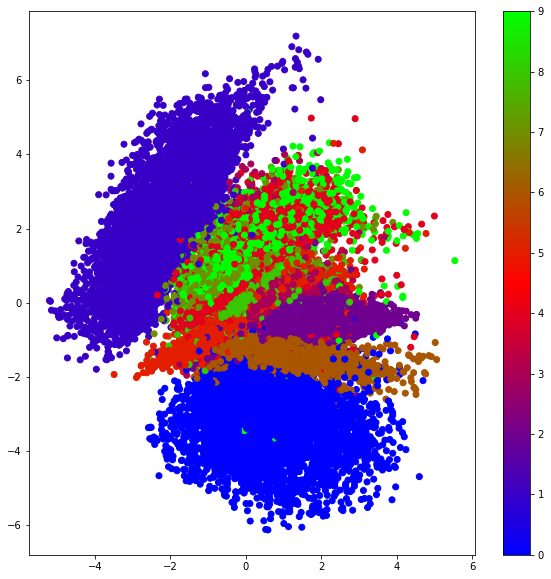

In [23]:
plt.figure(figsize=(10, 10))
plt.scatter(df['x0'], df['x1'], c=df['label'], cmap='brg')
plt.colorbar()
plt.show()